# 第十一週：Text Presentation
本周課程為「Text Presentation」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers以及API取得embeddings。


### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：uncased / chinese / multilingual
  *   大模型（LLM）：
      *   API based
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [12]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/sma') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['raw_data', 'dict', 'tmunlp_1.6B_WB_50dim_2020v1.bin']

In [13]:
!pip install scikit-learn-extra
!pip install jieba

In [14]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

讀入dcard推甄資料集

In [15]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [16]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

資料來源：
+ 工作流程平台蒐集DCARD 研究所版文章
+ 關鍵字:「推甄」(1630筆)
+ 時間: 2023-12-12 ~ 2024-03-12

In [17]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/sma_dcard_articleMetaData.csv')

In [18]:
origin_data

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/graduate_school/p/25428...,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,graduate_school,13,資訊工程學系,M,國立臺灣海洋大學
1,2,Dcard,https://www.dcard.tw/f/graduate_school/p/25429...,2023-12-31 05:34:01,想問一下各位學長姐，專題找涼的還是說選做的東西是好的？,如題，目前到了要加實驗室的時候，很糾結到底要選哪個方向，因為我自己一定是考研不會是推甄，不知...,graduate_school,8,應用材料及光電工程學系,M,國立暨南國際大學
2,3,Dcard,https://www.dcard.tw/f/graduate_school/p/25429...,2023-12-31 13:39:52,是否要繼續撐下去,原本小弟我讀的是另一間國立地名，當時想說第一志願沒上就重考一年，只不過被大學時的指導教授推薦...,graduate_school,3,cso9005,M,KKR
3,4,Dcard,https://www.dcard.tw/f/graduate_school/p/25428...,2023-12-30 04:46:11,壓線完成碩論文，大齡研究生的心路歷程,分享這幾年來無助的碩士論文心路歷程，中間經歷工作、休學，邊工作邊寫論文，幾乎快用完了碩士可以...,graduate_school,14,NaN,F,國立臺灣大學
4,5,Dcard,https://www.dcard.tw/f/graduate_school/p/25428...,2023-12-30 05:05:28,（請益）彰師大電子所,請問彰師大教授 有做嵌入式系統相關領域的教授嗎？\n我自己查只查到黃教授有，請問還有其他教授...,graduate_school,3,NaN,M,國立虎尾科技大學
...,...,...,...,...,...,...,...,...,...,...,...
909,910,Dcard,https://www.dcard.tw/f/graduate_school/p/25443...,2024-01-16 12:55:40,中山通訊甲備取生騷擾訊息,我理解現在還在等備取的同學應該都會焦慮，所以一開始你來私訊我的時候我也是友善回覆。但以下有幾...,graduate_school,95,NaN,F,國立中山大學
910,911,Dcard,https://www.dcard.tw/f/graduate_school/p/25444...,2024-01-17 05:19:33,（幫人代發）台大工工甲組報到,拜託有沒有甲組確定一定不會去的同學能動動小手點選放棄🥹🥹\n因為朋友差幾個就能備上了，拜託各...,graduate_school,0,NaN,M,國立臺灣科技大學
911,912,Dcard,https://www.dcard.tw/f/graduate_school/p/25444...,2024-01-17 05:57:12,可以不要再卡了嗎？,真的搞不懂到底有些人在卡什麼\n已經問了一整個月都找不到教授有沒有想過是自己的問題？\n大學...,graduate_school,91,NaN,M,國立成功大學
912,913,Dcard,https://www.dcard.tw/f/graduate_school/p/25444...,2024-01-17 12:38:14,112學年度 私立大學甄試+考試入學 陽明交大 生命科學院 生化暨分子生物研究所 甄試入學+...,發文目的：陽明生化所的碩士班入學文覺得偏少 希望能造福之後想考陽明生化的學弟妹\n\n身份：...,graduate_school,1,mei1032,F,mei1032


In [8]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['gender', 'boardID', 'commentCount', 'artUrl', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /content/drive/MyDrive/sma/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/sma/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u0045a266ccd5ee1e0d4c8a1f5214c678.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u0045a266ccd5ee1e0d4c8a1f5214c678.cache
Loading model cost 2.908 seconds.
DEBUG:jieba:Loading model cost 2.908 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artDate,artTitle,artContent,department,school,sentence,word
0,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,最近學期結束,"[最近, 學期結束]"
2,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,趁著現在很閒,"[現在, 很閒]"
3,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,趕快分享一下,"[分享, 一下]"
4,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,算是感謝之前在板上受到的幫助,"[算是, 感謝, 之前, 受到, 幫助]"
5,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,前言有鑑於前幾年有關海大資工的推甄心得較少,"[前言, 有鑑於, 幾年, 海大, 資工, 心得]"
...,...,...,...,...,...,...,...,...
21909,914,2024-02-17 11:51:48,筆試放榜前請教授寫推薦信請益,想問板上的大家！\n\n簡章上寫進到面試關會需要繳交1-2封推薦信，\n由於筆試放榜的隔天就...,NaN,國立臺灣大學,由於筆試放榜的隔天就要上傳備審資料,"[筆試, 放榜, 隔天, 就要, 上傳, 備審, 資料]"
21910,914,2024-02-17 11:51:48,筆試放榜前請教授寫推薦信請益,想問板上的大家！\n\n簡章上寫進到面試關會需要繳交1-2封推薦信，\n由於筆試放榜的隔天就...,NaN,國立臺灣大學,怕到時候會來不及,[到時候]
21911,914,2024-02-17 11:51:48,筆試放榜前請教授寫推薦信請益,想問板上的大家！\n\n簡章上寫進到面試關會需要繳交1-2封推薦信，\n由於筆試放榜的隔天就...,NaN,國立臺灣大學,但在還不確定能不能進到面試的情況下要請教授寫推薦信,"[還不, 確定, 面試, 情況, 下要, 請教, 授寫, 推薦信]"
21912,914,2024-02-17 11:51:48,筆試放榜前請教授寫推薦信請益,想問板上的大家！\n\n簡章上寫進到面試關會需要繳交1-2封推薦信，\n由於筆試放榜的隔天就...,NaN,國立臺灣大學,想請問各位認為向教授說明比較好,"[請問, 認為, 教授, 說明, 比較]"


### word2vec


####（1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram，以下為Phrases函式的使用示範

In [9]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new_york']


實際應用在資料集上

In [10]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artDate,artTitle,artContent,department,school,sentence,word,word_list_bigrams
0,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,最近學期結束,"[最近, 學期結束]","[最近, 學期結束]"
2,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,趁著現在很閒,"[現在, 很閒]","[現在, 很閒]"
3,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,趕快分享一下,"[分享, 一下]","[分享, 一下]"
4,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,算是感謝之前在板上受到的幫助,"[算是, 感謝, 之前, 受到, 幫助]","[算是, 感謝, 之前, 受到, 幫助]"
5,1,2023-12-30 14:20:06,113海大應屆資工所推甄心得分享,最近學期結束，該忙的都忙完了，趁著現在很閒，趕快分享一下，算是感謝之前在板上受到的幫助！\n...,資訊工程學系,國立臺灣海洋大學,前言有鑑於前幾年有關海大資工的推甄心得較少,"[前言, 有鑑於, 幾年, 海大, 資工, 心得]","[前言, 有鑑於, 幾年, 海大, 資工, 心得]"


In [11]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

最常出現的前十個字

In [12]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 15579


['教授', '面試', '研究', '老師', '問題', '比較', '學長', '時間', '準備', '實驗室']

In [13]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 20782
average length of sentences: 4.853094023674333


Word2Vec 計算

In [14]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [15]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [16]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

與**實驗室**最相關的字詞

In [17]:
# 檢查最相關的字
w2v_model.wv.most_similar('實驗室',topn=10)

[('評價', 0.9461271166801453),
 ('有沒有', 0.9239295721054077),
 ('幾位', 0.9216040372848511),
 ('風氣', 0.9179211854934692),
 ('面談', 0.916464626789093),
 ('推薦', 0.9155663251876831),
 ('兩位', 0.9107111096382141),
 ('詢問', 0.905293345451355),
 ('知道', 0.899773359298706),
 ('老師', 0.8975861668586731)]

與**工作**最相關的字詞

In [18]:
w2v_model.wv.most_similar('工作',topn=10)

[('比賽', 0.9903529286384583),
 ('修課', 0.9893258213996887),
 ('規劃', 0.9858286380767822),
 ('專案', 0.9852586984634399),
 ('研討會', 0.983545184135437),
 ('架構', 0.9830749034881592),
 ('國際', 0.9822692275047302),
 ('證明', 0.9816603064537048),
 ('提及', 0.9814730286598206),
 ('困難', 0.9806743264198303)]

與**準時,論文**最相關的字詞

In [19]:
w2v_model.wv.most_similar(['準時','論文'],topn=10)

[('不到', 0.98297119140625),
 ('了解', 0.9712458848953247),
 ('接受', 0.9696776270866394),
 ('說明', 0.9664323925971985),
 ('研究生', 0.9655253887176514),
 ('容易', 0.9635125398635864),
 ('直接', 0.9625990986824036),
 ('收滿', 0.9617608189582825),
 ('不錯', 0.9607682228088379),
 ('指導教授', 0.9597121477127075)]

與**準時,論文**最不相關的字詞

In [20]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['準時','論文'],topn=10)

[('面試', -0.4885108172893524),
 ('準備', -0.5290778875350952),
 ('分鐘', -0.5442782640457153),
 ('推甄', -0.6025266051292419),
 ('計畫', -0.6100530028343201),
 ('考試', -0.6262295842170715),
 ('研究', -0.6267447471618652),
 ('備取', -0.6332671642303467),
 ('過程', -0.6465839147567749),
 ('心得', -0.6510313153266907)]

In [21]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("畢業","工作")

0.7329655

In [22]:
w2v_model.wv.similarity("計畫","薪水")

0.56493455

In [23]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["計畫", "薪水", '工作'])

'計畫'

In [24]:
# 相對關係
w2v_model.wv.most_similar(positive=["計畫"], negative=["工作"], topn=5)

[('方向', 0.1713600605726242),
 ('大專生', 0.09397890418767929),
 ('領域', 0.07834834605455399),
 ('動機', 0.06887618452310562),
 ('研究', 0.06808751076459885)]

In [25]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [26]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [27]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [28]:
getVecs(w2v_model,["計畫","薪水"])

array([[-8.74633342e-03,  4.20484811e-01, -1.80705115e-01,
         5.23306541e-02,  2.68657088e-01, -1.18072405e-01,
         1.68545216e-01,  5.16339056e-02,  2.66670197e-01,
        -2.23018736e-01, -1.45270541e-01,  2.33488485e-01,
        -5.79137802e-01,  2.71882564e-01,  1.26281634e-01,
        -1.03969745e-01,  8.27372000e-02,  3.59787345e-01,
         1.47386745e-01,  2.55476117e-01,  7.11199045e-02,
        -7.05119446e-02,  4.84127015e-01,  5.56125455e-02,
        -3.23245376e-02,  1.63247705e-01,  2.09473446e-01,
         5.60573824e-02,  2.04406247e-01, -2.47912720e-01,
         2.20778838e-01,  2.13546783e-01, -1.25513494e-01,
         9.76695344e-02,  2.04657778e-01, -7.15229034e-01,
        -8.82287920e-02,  1.77982047e-01,  3.89739014e-02,
        -9.43873152e-02, -4.81991395e-02, -3.28035980e-01,
        -2.28698686e-01, -1.78677849e-02, -1.56000573e-02,
        -2.95724511e-01,  1.87548742e-01,  3.49916667e-01,
        -3.40097725e-01, -4.01830912e-01,  4.41887021e-0

In [29]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [30]:
expandPosWord(w2v_model,["計畫","實驗室"],top_n = 10)

['推薦',
 '領域',
 '方法',
 '兩位',
 '國科會',
 '大專生',
 '方向',
 '面談',
 '經歷',
 '幾位',
 '評價',
 '助理',
 '知道',
 '詢問',
 '主題',
 '老師',
 '團隊',
 '風氣',
 '有沒有',
 '動機']

In [32]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    font_path = '/content/drive/MyDrive/sma/raw_data/SourceHanSansTW-Regular.otf'  # Your font path goes here
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()

    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [33]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [34]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

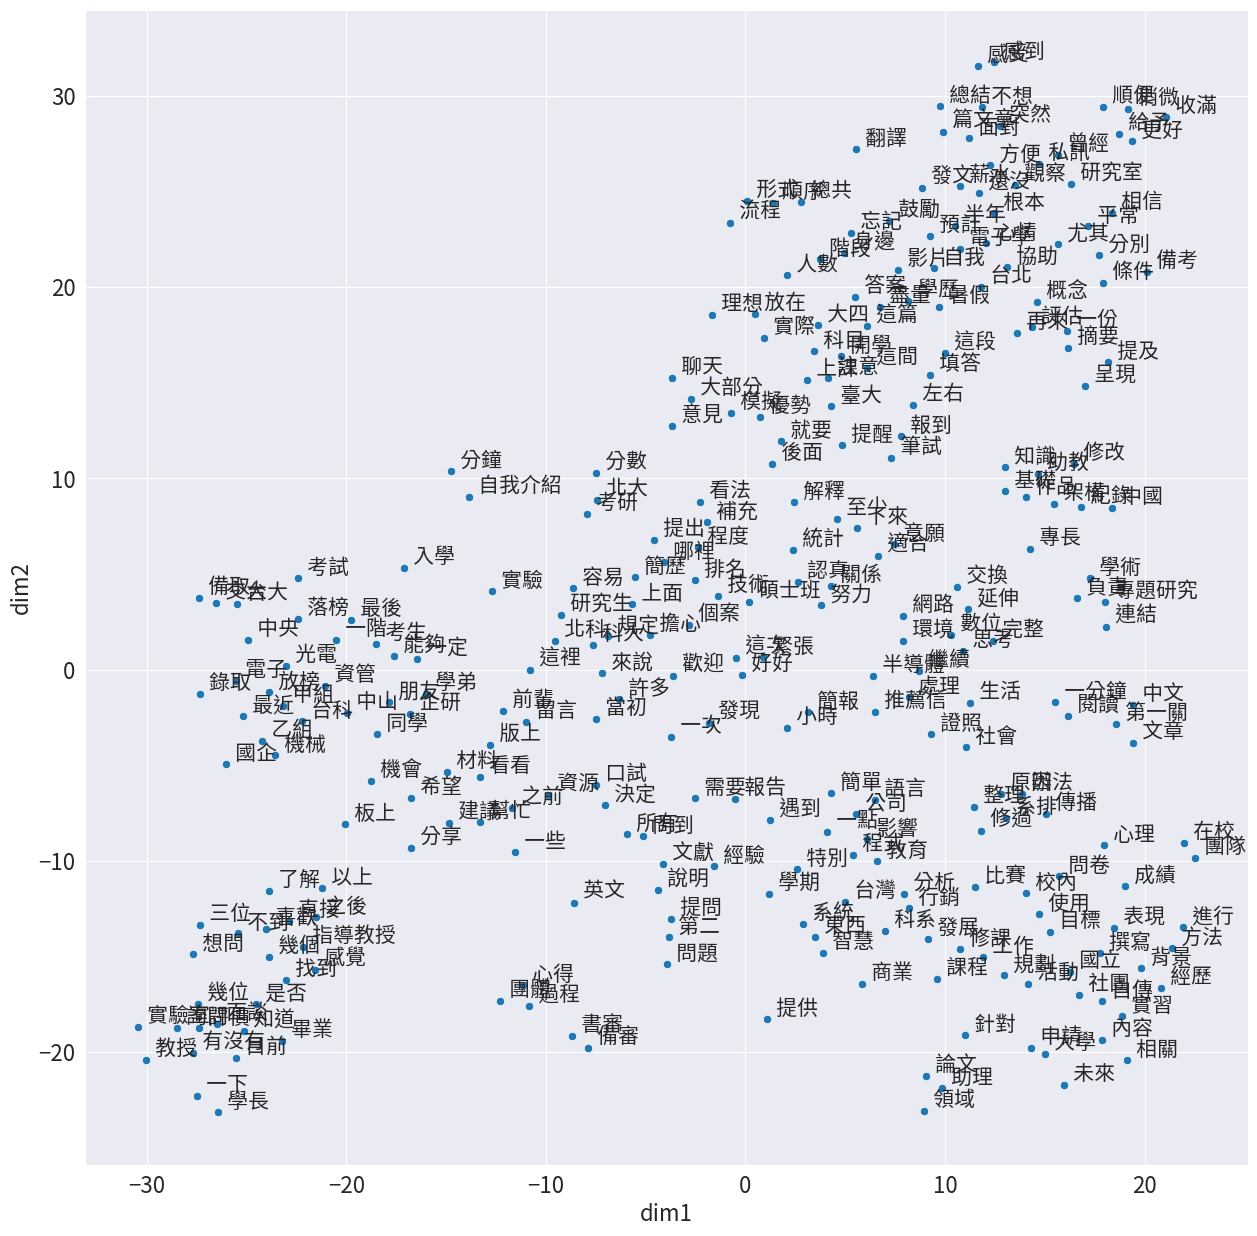

In [35]:
plotScatter(word_df)

3D 散狀圖

In [36]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [37]:
!pip install scikit-learn-extra

In [38]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [39]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



####（2）如何使用別人訓練好的word2vec模型

臺北醫學大學做的預訓練 Word2Vec 模型，來源：http://nlp.tmu.edu.tw/word2vec/index.html

In [40]:
model_tmu = KeyedVectors.load_word2vec_format('./tmunlp_1.6B_WB_50dim_2020v1.bin', unicode_errors='ignore', binary=True)

In [41]:
model_tmu.most_similar('死因',topn=10)

[('死亡率', 0.701721727848053),
 ('發生率', 0.674872875213623),
 ('肺癌', 0.6719512939453125),
 ('病例', 0.6697904467582703),
 ('墜傷', 0.6637092232704163),
 ('癌症', 0.639916181564331),
 ('自殺率', 0.6343487501144409),
 ('大腸癌', 0.619469940662384),
 ('危險群', 0.6183907389640808),
 ('衛王', 0.6170127987861633)]

In [42]:
model_tmu.most_similar('確診',topn=10)

[('篩檢出', 0.8213565945625305),
 ('檢查出', 0.8039812445640564),
 ('發病', 0.8021178841590881),
 ('確診為', 0.7891691327095032),
 ('感染', 0.7412698268890381),
 ('診斷出', 0.7407408356666565),
 ('染病', 0.7362218499183655),
 ('肺結核', 0.7344413995742798),
 ('罹病', 0.7330865859985352),
 ('投藥', 0.7322354912757874)]

In [43]:
model_tmu.most_similar(positive=['疾病','死因'],topn=10)

[('癌症', 0.8115928173065186),
 ('肺癌', 0.7952209711074829),
 ('腎臟病', 0.7660067081451416),
 ('病症', 0.7655640840530396),
 ('糖尿病', 0.7653897404670715),
 ('死亡率', 0.739435076713562),
 ('慢性病', 0.7372105121612549),
 ('大腸癌', 0.7370118498802185),
 ('病例', 0.731032133102417),
 ('發生率', 0.7300099730491638)]

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
from sentence_transformers import SentenceTransformer, models, util

#### 小模型，以BERT為範例

註：在挑選語言模型時需確認其訓練資料的來源，因為不一定都具備跨語言的能力。   
接下來將以針對英文、中文以及多語言進行訓練的三種BERT模型做範例。

In [46]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [47]:
bert_en.get_max_seq_length()

512

In [48]:
example_text = "This framework generates embeddings for each input sentence"
example_embeddings = bert_en.encode(example_text)

print(example_embeddings.shape)
print("=======================")
print(example_embeddings)

(768,)
[-1.25634506e-01 -2.35394128e-02  9.72141698e-02 -2.14602068e-01
 -4.24759798e-02 -7.68916402e-03  1.66508600e-01  2.09751755e-01
  1.94057435e-01 -9.31541771e-02 -1.04051076e-01 -1.99633613e-01
 -3.48384231e-01  8.10464770e-02 -1.62067972e-02  1.90525934e-01
  5.29247976e-04  1.45439327e-01 -5.53637161e-04 -1.58491105e-01
  1.94275483e-01  1.59165829e-01 -5.99901617e-01  2.65522152e-01
  7.47945905e-01 -2.46572960e-03  1.04436599e-01  1.66958466e-01
 -3.53779286e-01  1.39418691e-01  3.89937088e-02  6.57109916e-01
 -6.23248192e-03 -2.85024047e-01 -1.56141147e-01  8.45851153e-02
  1.65655375e-01 -2.55370378e-01 -1.16442733e-01  9.59286317e-02
 -6.72327101e-01 -3.47994864e-01  8.42589587e-02 -2.06027731e-01
 -5.32228500e-02 -4.90707040e-01 -9.41141788e-03 -3.81041706e-01
  5.67958727e-02 -6.35588527e-01 -1.04700661e+00  3.73333395e-01
  1.31077528e-01  3.08177173e-01 -2.27984130e-01  8.04124296e-01
  1.21666558e-01 -7.21639931e-01  3.69302422e-01 -1.17349945e-01
  1.25592634e-01 -

In [49]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_en = bert_en.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_en, embeddings_en)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.880907
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.499376
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.480858


因為後續在查看結果時會一直使用到此程式碼，所以包成function以便之後使用。

In [6]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [21]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [52]:
# 示範句子
sentences = [
    "今天天氣很好。",
    "今天是個晴空萬里的好天氣。",
    "我晚上想去公園散步。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
0,今天天氣很好。,今天是個晴空萬里的好天氣。,0.914067
1,今天天氣很好。,我晚上想去公園散步。,0.787589
2,今天是個晴空萬里的好天氣。,我晚上想去公園散步。,0.759642


多語言 bert-base-multilingual-cased

In [53]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

In [54]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.588525
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.362766
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.350700


#### 大模型範例

In [55]:
!pip install tiktoken
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=f4451f7b8e85044b426c3b06eed2b8a0064be633b1da31971ed97f3cd04285d1
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


#### (1)API based

##### OpenAI

**注意**   
Openai的API會要求綁定信用卡後才能使用，且綁定信用卡後會刷5美金的初始費用。   
請自行斟酌是否要嘗試這一部分的程式碼！


In [56]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00


In [58]:
# from openai import OpenAI
import openai
import os

openai.api_key = '你的API_KEY' # 設置API_KEY

def get_embedding_openai(text, model):
   #text = text.replace("\n", " ")
   return openai.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 取得每一句的embedding
embeddings_openai = [get_embedding_openai(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_openai, embeddings_openai)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

##### Cohere

In [59]:
!pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00


In [60]:
import cohere

co = cohere.Client("aWm3xDAyIpLR3wK9icFXFhPRyudfgNZRXJ3TzfVp") # 設置API_KEY

embedding_model = "embed-multilingual-v3.0"

def get_embedding_cohere(text, model):
   #text = text.replace("\n", " ")
   return co.embed(texts=[text], model=model, input_type="classification").embeddings[0]

In [61]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。",
    "速い茶色のキツネが怠惰な犬を飛び越える"
]

# 使用 encode() 對資料做embedding
embeddings_cohere = [get_embedding_cohere(text, model=embedding_model) for text in sentences]

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_cohere, embeddings_cohere)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
5,敏捷的棕色狐狸跳過了懶惰的狗。,速い茶色のキツネが怠惰な犬を飛び越える,0.707117
3,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.706838
4,The quick brown fox jumps over the lazy dog.,速い茶色のキツネが怠惰な犬を飛び越える,0.631464
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.278902
2,This framework generates embeddings for each i...,速い茶色のキツネが怠惰な犬を飛び越える,0.261264
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.226791


#### (2) Open Source LLM

##### LLaMA2

In [4]:
from huggingface_hub import notebook_login
notebook_login() # 輸入Hugging Face 帳號的Token

In [ ]:
model_llama = SentenceTransformer('meta-llama/Llama-2-7b-hf')

model_llama.tokenizer.pad_token = model_llama.tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy white fox leaps across the dog."
]

# 使用 encode() 對資料做embedding
embeddings_llama = model_llama.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_llama, embeddings_llama)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

NameError: name 'model_llama' is not defined

##### Phi-2

In [4]:
model_phi2 = SentenceTransformer('microsoft/phi-2')

model_phi2.tokenizer.pad_token = model_phi2.tokenizer.eos_token
# embeddings = model_phi2.encode(['This is example of using phi2'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_phi2 = model_phi2.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_phi2, embeddings_phi2)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.828456
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.745846
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.691689


這裡需注意一下，上述的兩個LLM基本上是decoder-only，它們主要的任務目標是要生成下一個字，並不是主要拿來做sentence embedding的。   
有興趣的同學可以參考[embedding相關任務的leaderboard](https://huggingface.co/spaces/mteb/leaderboard)，試試上面的模型。

### 使用embedding做NLP任務

#### 相似文件

In [19]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

<ipython-input-19-ba0ea2bb5f29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


,system_id,artTitle,artContent
0,1,113海大應屆資工所推甄心得分享,最近學期結束該忙的都忙完了趁著現在很閒趕快分享一下算是感謝之前在板上受到的幫助前言有鑑於前幾...
1,2,想問一下各位學長姐，專題找涼的還是說選做的東西是好的？,如題目前到了要加實驗室的時候很糾結到底要選哪個方向因為我自己一定是考研不會是推甄不知道如果我...
2,3,是否要繼續撐下去,原本小弟我讀的是另一間國立地名當時想說第一志願沒上就重考一年只不過被大學時的指導教授推薦另一...
3,4,壓線完成碩論文，大齡研究生的心路歷程,分享這幾年來無助的碩士論文心路歷程中間經歷工作休學邊工作邊寫論文幾乎快用完了碩士可以使用的休...
4,5,（請益）彰師大電子所,請問彰師大教授有做嵌入式系統相關領域的教授嗎我自己查只查到黃教授有請問還有其他教授有做這領域嗎


In [22]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 研究所考古題

 資料集中前五相似的文章:
研究所考古題 (Score: 1.0000)
口試被教授問有什麼問題想問的嗎
要如何回答 (Score: 0.9504)
成大工科丙出路 (Score: 0.9495)
專題對理院跨考電機的必要性 (Score: 0.9459)
大專生研究計畫 資格？ (Score: 0.9441)






In [23]:
query_num = 30

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 113年應屆非本科諮商所推甄心得分享

 資料集中前五相似的文章:
113年應屆非本科諮商所推甄心得分享 (Score: 1.0000)
113應屆非本科系推甄心輔所心得⺣̤̬（文長） (Score: 0.9890)
113諮商心理、輔導研究所推甄分享-【貳、資料撰寫篇】 (Score: 0.9875)
113諮商心理、輔導研究所推甄分享—【壹、心路歷程篇】 (Score: 0.9871)
【113非應屆推甄分享】政大企研｜成大企研｜中山企研｜中央企研｜台科企研｜台科MBA| (Score: 0.9858)




